In [1]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tv
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from PIL import Image
import logging
import matplotlib.pyplot as plt
import copy
import pandas as pd
%matplotlib inline

In [2]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("training.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)

In [3]:
model_path = "melanoma_classification_ResNet18.pt"
n_of_epochs = 25

In [4]:
def load_model(model_path):
    ''' Loads a model and its state dict. Accepts path to the model, returns the model and all associated data.
    Default CNN type is resnet18 '''
    loaded_model = {}
    saved_model = torch.load(f'{model_path}')
    loaded_model["labeling mode"] = saved_model['labeling_mode']
    loaded_model['img paths'] =  saved_model['img_paths']
    loaded_model['project name'] = saved_model['project_name']
    loaded_model['categories data'] = saved_model['сategories_data']
    loaded_model['model name']  = saved_model['model_name']
    loaded_model['optim state dict'] = saved_model['optimizer_state_dict']
    loaded_model['model state dict'] = saved_model['model_state_dict']
    loaded_model['prev training stats'] = saved_model['model_stats']
    loaded_model['img lists'] = saved_model['img_lists']
    loaded_model['metadata'] = saved_model['metadata']
    
    mylogs.info("Model: " + loaded_model['model name'])
    img_channels = loaded_model['metadata']
    num_classes = len(loaded_model['categories data'][0])
    import resnet
    if loaded_model['model name'] == 'ResNet18':
            model = resnet.ResNet18(img_channels, num_classes)
    elif loaded_model['model name'] == 'ResNet34':
            model = resnet.ResNet34(img_channels, num_classes)
    elif loaded_model['model name'] == 'ResNet50':
            model = resnet.ResNet50(img_channels, num_classes)
    elif loaded_model['model name'] == 'ResNet101':
            model = resnet.ResNet101(img_channels, num_classes)
    elif loaded_model['model name'] == 'ResNet152':
            model = resnet.ResNet152(img_channels, num_classes)
    else:
            model = resnet.ResNet18()
    model.load_state_dict(loaded_model['model state dict'])
    loaded_model['model'] = model
    model.train()

    return  loaded_model


In [5]:
loaded_model = load_model(model_path)

Model: ResNet18


In [6]:
labeling_mode = loaded_model["labeling mode"]
train_dir, val_dir, test_dir = loaded_model['img paths']
project_name =  loaded_model['project name']
categories_data = loaded_model['categories data']
model_name = loaded_model['model name']
optim_state_dict = loaded_model['optim state dict']
model_state_dict = loaded_model['model state dict']
prev_training_stats = loaded_model['prev training stats']
train_img_list, val_img_list, test_img_list = loaded_model['img lists']
img_channels = loaded_model['metadata']
metadata = loaded_model['metadata']
categories = categories_data[0]
model = loaded_model['model']
categories_weights = categories_data[1]


In [7]:
if categories_data[2]:
    labels_file, columns_to_select = csv_options

In [8]:
mylogs.info("Binary Classification")

Binary Classification


In [9]:
def csv_to_dict(columns_to_select, categories, labels_file):
    labels_file = pd.read_csv(labels_file)
    labels_file = labels_file.iloc[:,list(columns_to_select)]
    return(dict(zip(labels_file.iloc[:,0], labels_file.iloc[:,1])))

In [10]:
class ImgLabeler:
    def __init__(self, label_mode, img_dir, img_list, categories, labels_file=None, columns_to_select = None):
        self.label_mode= label_mode
        self.img_dir = img_dir
        self.categories = categories 
        self.img_list = img_list
        self.labels_file = labels_file
        
        #### if the labels are in the csv file    
        if self.labels_file and columns_to_select:
            self.labels_file = csv_to_dict(columns_to_select, categories, self.labels_file)
        #### if the labels are in the folder or file name   
        
        self.name_label_dic = dict.fromkeys(self.img_list, None)
        #For each file_path its category (filename, dir or from csv) is transformed to int
        for file_path in self.name_label_dic:
            file_name = os.path.basename(file_path)
            file_dir = os.path.basename(os.path.dirname(file_path))

            #Checking if in from csv labeling
            if self.labels_file and columns_to_select:
                file_category_from_csv = self.labels_file[file_name]
            else:
                file_category_from_csv = ['No prior label']
            for category in categories:
                self.category_is_present = 0
                if category == file_dir and label_mode == 'folder':
                    self.name_label_dic[file_path] = (category, categories.index(category))
                elif category == file_name and label_mode == 'file name':
                    self.name_label_dic[file_path] = (category, categories.index(category))
                elif category == file_category_from_csv and label_mode == 'csv file':
                    self.name_label_dic[file_path] = (category, categories.index(category))
                # if no category is found
            if self.name_label_dic[file_path] == None:
                self.name_label_dic[file_path] = (categories[-1], len(categories)-1)
    def return_categories_stat(self):
        return (self.img_dir, len(self.name_label_dic), len(self.categories) - 1)
    def return_row(self, file_path):
        return self.name_label_dic[file_path]

In [11]:
if categories_data[2]:
    img_labeler_train = ImgLabeler(labeling_mode, train_dir,train_img_list, categories,  labels_file, columns_to_select)
    img_labeler_val = ImgLabeler(labeling_mode, val_dir, val_img_list, categories,  labels_file, columns_to_select)
else:
    img_labeler_train = ImgLabeler(labeling_mode, train_dir,train_img_list, categories)
    img_labeler_val = ImgLabeler(labeling_mode, val_dir,val_img_list,  categories)
img_labeler_test = ImgLabeler(labeling_mode, test_dir,test_img_list, categories)

In [12]:
mylogs.info(f"Training set{img_labeler_train.return_categories_stat()}")
mylogs.info(f"Validation set{img_labeler_val.return_categories_stat()}")
mylogs.info(f"Testing set{img_labeler_test.return_categories_stat()}")

Training set('E:/melanoma/train/', 8545, 2)
Validation set('E:/melanoma/train/', 2137, 2)
Testing set('E:/melanoma/test/', 3561, 2)


# Image Loading functions

In [13]:
if img_channels == 3:
    dimensions = ((0,0,0), (1,1,1))
elif img_channels == 1:
    dimensions = ((0), (1))

In [14]:
def get_train_transform(dimensions):
    return tv.Compose([
        tv.RandomHorizontalFlip(p=0.5),
        tv.RandomRotation(15),
        tv.RandomCrop(204),
        tv.RandomVerticalFlip(),
        tv.ToTensor(),
        tv.Normalize(dimensions[0],dimensions[1])
    ])
    
    
def get_val_transform(dimensions):
    return tv.Compose([
        tv.ToTensor(),
            tv.Normalize(dimensions[0],dimensions[1])
        ])

In [15]:
class loadDataset(Dataset):
    def __init__(self, img_labeler, mode, transforms):
        super().__init__()
        self.img_labeler = img_labeler
        self.categories = self.img_labeler.categories
        self.imgs = self.img_labeler.img_list
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        image_path = self.imgs[idx]
      ### Reading, converting and normalizing image
        if self.mode == "train" or self.mode == "val":
            ### Reading, converting and normalizing image
            img = Image.open(image_path)
            img = img.resize((224, 224))
            
            # obtaining label for image
            label  = self.img_labeler.return_row(image_path)[1]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)
            return img, label
        
        elif self.mode == "test":
            ## Reading, converting and normalizing image
            img = Image.open(image_path)
            img = img.resize((224, 224))
            # if there is no prior categories
            if self.img_labeler.return_row(image_path) == None:
                label  = len(categories)-1
            else: 
                label  = self.img_labeler.return_row(image_path)[1]
            label = torch.tensor(label, dtype = torch.float32)
            ### Apply Transforms on image
            img = self.transforms(img)
            return img, label
        
    def __len__(self):
        return len(self.imgs)

In [16]:
train_dataset = loadDataset(img_labeler_train, mode = "train", 
                            transforms = get_train_transform(dimensions))
val_dataset = loadDataset(img_labeler_val, mode = "val", 
                          transforms = get_val_transform(dimensions))
test_dataset = loadDataset(img_labeler_test, mode = "test", 
                         transforms = get_val_transform(dimensions))

In [17]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 24,
    pin_memory = True,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 0,
    batch_size = 24,
    pin_memory = True,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 0,
    batch_size = 1,
    shuffle = True
)

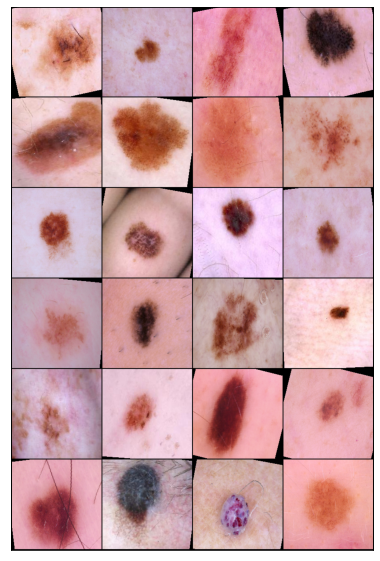

In [18]:
def dataset_preview(train_data_loader):
    for images, labels in train_data_loader:
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 4).permute(1,2,0))
        break
        
dataset_preview(train_data_loader)

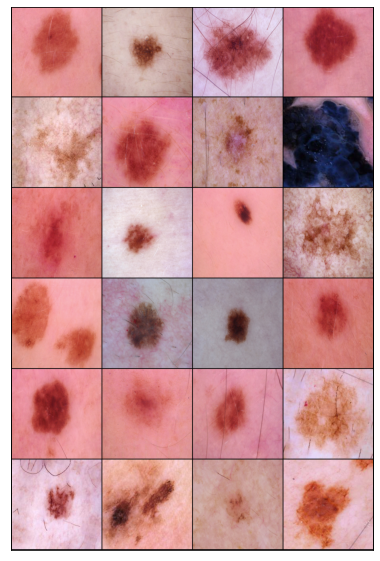

In [19]:
dataset_preview(val_data_loader)

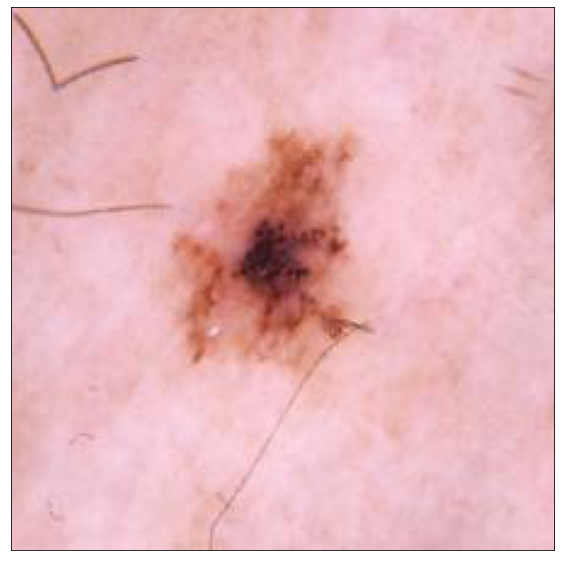

In [20]:
dataset_preview(test_data_loader)

# Functions for training

In [21]:
class Optimizer:
    def __init__(self, model):
        self.optimizer_dict = {}
        self.optimizer_dict['optimizer'] = torch.optim.Adam(model.parameters(), lr = 0.0001)
        self.optimizer_dict['lr_scheduler'] = torch.optim.lr_scheduler.StepLR(self.optimizer_dict['optimizer'], step_size = 5, gamma = 0.5)
        self.optimizer_dict['criterion'] = nn.BCELoss()

    def return_state_dict(self):
        return self.optimizer_dict['optimizer'].state_dict()

In [22]:
mylogs.info("Loaded model: " + model_name )
mylogs.info(f"Continuing training from {prev_training_stats['best epoch']}"  )

# Loading model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")
model.to(device)
optimizerA = Optimizer(model)
optimizerA.optimizer_dict['optimizer'].load_state_dict(optim_state_dict)

Loaded model: ResNet18
Continuing training from 6
Device is: cuda


In [23]:
def accuracy(preds, trues):
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    acc = np.sum(acc) / len(preds)
    return (acc * 100)
    

In [24]:
def train_one_epoch(data_loader, optimizer_obj, phase):
    optimizer = optimizer_obj.optimizer_dict['optimizer']
    criterion = optimizer_obj.optimizer_dict['criterion']
    lr_scheduler = optimizer_obj.optimizer_dict['criterion'] 
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in data_loader:
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        #Reseting Gradients
        optimizer.zero_grad()
        #Forward
        preds = model(images)
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        #Backward if train phase
        if phase == "train":
            _loss.backward()
            optimizer.step()
            
    ###Overall Epoch Results
    end_time = time.time()
    total_time = int(end_time - start_time)/60
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    ###Storing results to logs
    return epoch_loss, epoch_acc, total_time

In [25]:
def report_in_progress(phase, epoch, loss, acc, _time):
       #Print Epoch Details
        mylogs.info(f'{"Training" if phase == False else "Validation"} Epoch {epoch}: | Loss: {loss:.5f} | Acc: {acc:.3f} | Time: {(round(_time, 4))}')

In [26]:
def train_model(model, optimizer_obj, prev_train_stats, max_n_epochs,early_stop_epoch_thresh = 10):
    start_time = time.time()
    # initializing  training stats
    train_logs =  prev_train_stats['best train logs']
    val_logs = prev_train_stats['best validation logs'] 
    mylogs.info("Training continued")
    best_model = model
    best_epoch = prev_train_stats['best epoch']
    best_val_acc = prev_train_stats['best validation acc']
    bad_acc_epoch = 0
    current_epoch = prev_train_stats['current epoch'] + 1
    best_train_logs = {}
    best_val_logs = {}
    best_model_optimizer_state_dict = optimizer_obj.return_state_dict()
 #   best_model_optimizer_state_dict = optimizer_obj.return_state_dict()
    
    for epoch in range(current_epoch, max_n_epochs + 1):
        if bad_acc_epoch < early_stop_epoch_thresh:
            current_epoch = epoch 
            ###Training
            train_loss, train_acc, train_time = train_one_epoch(train_data_loader, optimizer_obj, "train")
            #Print train Epoch Details      
            report_in_progress(0, epoch, train_loss, train_acc, train_time)
            #Adding stats for the epoch
            train_logs["loss"].append(train_loss)
            train_logs["accuracy"].append(train_acc)
            train_logs["time"].append(train_time)
            ###Validation
            val_loss, val_acc, val_time = train_one_epoch(val_data_loader, optimizer_obj, "validation")
            #Print Val Epoch  Details
            report_in_progress(1, epoch, val_loss, val_acc, val_time)
            #adding stats on the epoch
            val_logs["loss"].append(val_loss)
            val_logs["accuracy"].append(val_acc)
            val_logs["time"].append(val_time)
            # Early stop processing
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = copy.deepcopy(model)
                best_model_optimizer_state_dict = optimizer_obj.return_state_dict()
                bad_acc_epoch = 0
          
                best_train_logs = train_logs
                best_val_logs = val_logs
                best_epoch = epoch 
            else:
                bad_acc_epoch +=1
        else:
            mylogs.info(f"Early stop, best accuracy: {best_val_acc}%")
            break
    end_time = time.time()
    total_time = end_time - start_time
    mylogs.info(f"Total time : {int(total_time/60)}")
    # packing training data into a nice dictionary
    training_stats = {}
    training_stats['train logs'] = train_logs
    training_stats['validation logs'] = val_logs
    training_stats['best train logs'] = best_train_logs
    training_stats['best validation logs'] = best_val_logs
    training_stats['best validation acc'] = best_val_acc
    training_stats['best epoch'] = best_epoch
    training_stats['current epoch'] = current_epoch 
    
    return best_model, best_model_optimizer_state_dict, training_stats

In [27]:
# Continued training 
model, model_optimizer_state_dict, training_stats = train_model(model, optimizerA, prev_training_stats, n_of_epochs)

Training continued
Training Epoch 7: | Loss: 0.21002 | Acc: 91.363 | Time: 1.4667
Validation Epoch 7: | Loss: 0.18395 | Acc: 91.944 | Time: 0.4167
Training Epoch 8: | Loss: 0.17917 | Acc: 92.927 | Time: 1.25
Validation Epoch 8: | Loss: 0.20782 | Acc: 91.574 | Time: 0.3
Training Epoch 9: | Loss: 0.18566 | Acc: 92.040 | Time: 1.1833
Validation Epoch 9: | Loss: 0.19968 | Acc: 91.852 | Time: 0.3333
Training Epoch 10: | Loss: 0.17109 | Acc: 93.172 | Time: 1.3
Validation Epoch 10: | Loss: 0.17118 | Acc: 93.009 | Time: 0.3
Training Epoch 11: | Loss: 0.17959 | Acc: 92.402 | Time: 1.2833
Validation Epoch 11: | Loss: 0.16821 | Acc: 92.269 | Time: 0.3
Training Epoch 12: | Loss: 0.16671 | Acc: 92.904 | Time: 1.25
Validation Epoch 12: | Loss: 0.20466 | Acc: 91.343 | Time: 0.2667
Training Epoch 13: | Loss: 0.15658 | Acc: 93.569 | Time: 1.2167
Validation Epoch 13: | Loss: 0.20255 | Acc: 90.417 | Time: 0.2833
Training Epoch 14: | Loss: 0.15556 | Acc: 93.534 | Time: 1.25
Validation Epoch 14: | Loss: 0.

In [28]:
def train_vis(training_stats, prev_train_end):

    ### Plotting Results
    train_logs = training_stats['train logs']
    val_logs = training_stats['validation logs']
    epochs = training_stats['current epoch'] + 1
    best_epoch = training_stats['best epoch'] 

#Loss
    plt.title("Loss",color='black')
    plt.plot(np.arange(1, epochs), train_logs["loss"], color = 'blue', label='Training')
    plt.plot(np.arange(1, epochs), val_logs["loss"], color = 'orange', label='Validation')
    plt.axvline(x=prev_train_end,color='red')
    plt.axvline(x=best_epoch,color='green')
    plt.xticks(ticks=range(1, epochs), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Loss", color = 'black')
    plt.show()

#Accuracy
    plt.title("Accuracy", color='black')
    plt.plot(np.arange(1, epochs), train_logs["accuracy"], color = 'blue', label='Training')
    plt.plot(np.arange(1, epochs), val_logs["accuracy"], color = 'orange', label='Validation')
    plt.axvline(x=prev_train_end,color='red')
    plt.axvline(x=best_epoch, color='green')
    plt.xticks(ticks=range(1, epochs), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Accuracy", color='black')
    plt.show()

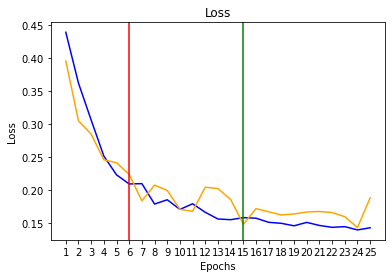

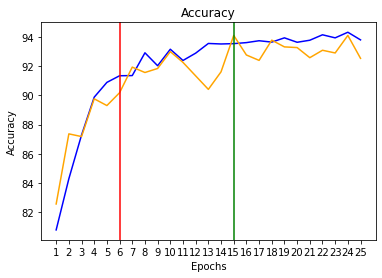

In [29]:
train_vis(training_stats,prev_training_stats['best epoch'])

In [30]:
# Saving the best model
def save_model(model, model_stats, model_name, best_model_optimizer_state_dict, img_channels,  categories_data):
    ''' Save model either for inference or for continuing training '''
    torch.save({'model_name': model_name,
                'сategories_data':  categories_data,
                'model_state_dict': model.state_dict(),
                'metadata': (img_channels)
                }, f'{project_name}_{model_name}_inference.pt')
    torch.save({'model_name': model_name,
                'img_paths': (train_dir,val_dir, test_dir),
                'optimizer_state_dict': model_optimizer_state_dict,
                'labeling_mode': labeling_mode,
                'project_name': project_name,
                'сategories_data': categories_data,
                'model_state_dict': model.state_dict(),
                'model_stats': training_stats,
                'img_lists':(train_img_list, val_img_list, test_img_list),
                'metadata': (img_channels)
                }, f'{project_name}_{model_name}.pt')
    mylogs.info("Model saved")

In [31]:
save_model(model, training_stats, model_name, model_optimizer_state_dict, img_channels, categories_data)

Model saved


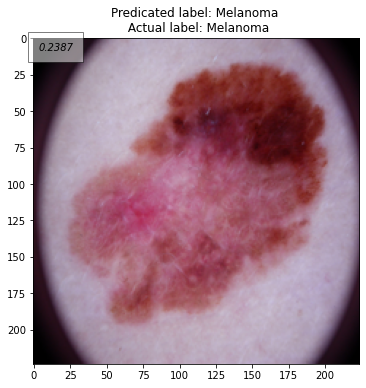

In [32]:
# Testing on a random test image 
for image, actual_label in test_data_loader:
    figure, ax = plt.subplots(figsize=(6,6))
    with torch.no_grad():
        # Generate prediction
        model.eval()
        image.to('cpu')
        model.to('cpu')
        prediction = model(image)
        actual_label = categories[int(actual_label)]
        predicted_label = [categories[1] if prediction >= 0.5 else categories[0]][0]
        plt.title(f'Predicated label: {predicted_label} \n Actual label: {actual_label}',
                  color= 'black')
        plt.imshow(make_grid(image,1).permute(1,2,0))
        ax.text(3, 8, (round(float(prediction), 4)), style='italic',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        break
    plt.show()

# F1-score and ROC-AUC curve

In [33]:
from sklearn.metrics import roc_curve, auc, f1_score
roc_auc_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 0,
    batch_size = 1,
    pin_memory = True,
    shuffle = True
)

In [34]:
def ytrue_ypred_gen(roc_auc_data_loader, n=3000):
    y_true = []
    y_pred = []
    y_pred_prob = []
    for image, actual_label in roc_auc_data_loader:
        with torch.no_grad():
            # Generate prediction
            y_true.append(int(actual_label))
            img = image.to(device)
            model.to(device)
            model.eval()
            prediction = float(model(img))
            y_pred.append([1 if prediction >= 0.5 else 0])
            y_pred_prob.append(prediction)
            predicted_label =  prediction 
            if len(y_true) > n:
                break
    return y_true, y_pred, y_pred_prob

In [35]:
def roc_auc_curve(y_true, y_pred_prob):
    y = np.array(y_true)
    scores = np.array(y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,color="darkorange",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

In [36]:
y_true, y_pred, y_pred_prob = ytrue_ypred_gen(roc_auc_data_loader)

In [37]:
f1_score(y_true, y_pred, average='macro')

0.9416181965595037

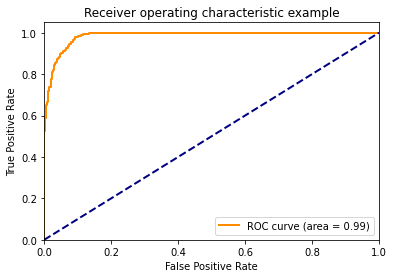

In [38]:
roc_auc_curve(y_true, y_pred_prob)